In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

### Data

In [2]:
features, labels = make_moons(n_samples=5000, random_state=42, noise=0.1)

In [3]:
features.shape, labels.shape

((5000, 2), (5000,))

In [4]:
features[:5]

array([[-0.1196884 ,  1.03684845],
       [ 0.03370055,  0.2493631 ],
       [ 0.03864294,  0.33033539],
       [ 0.22222051,  1.03355193],
       [ 0.74448612,  0.69288687]])

In [5]:
labels[:5]

array([0, 1, 1, 0, 0])

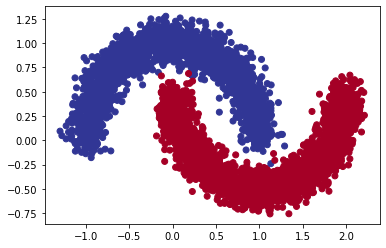

In [6]:
plt.scatter(features[:,0], features[:,1], c = labels, cmap = plt.cm.RdYlBu_r)

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [8]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 0.21420761 -0.05796994]
 [ 0.0032864   0.99425475]
 [-0.75284317  0.44580443]
 [ 0.54424186  0.97188029]
 [ 0.03637376  0.21158972]
 [ 0.82931269  0.36920001]
 [ 0.43561809 -0.28922571]
 [-0.55725086  0.75551574]
 [ 1.60814246 -0.10393687]
 [ 1.29565288 -0.42358266]], shape=(10, 2), dtype=float64) 
 tf.Tensor([1 0 0 0 1 0 1 0 1 1], shape=(10,), dtype=int64)


### Initializing Model Parameters

In [9]:
num_inputs = 2
num_outputs = 2
num_hiddens = 200

W1 = tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens), mean=0, stddev=0.01))
b1 = tf.Variable(tf.zeros(num_hiddens))
W2 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_hiddens), mean=0, stddev=0.01))
b2 = tf.Variable(tf.random.normal([num_hiddens], stddev=.01))
W3 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_outputs), mean=0, stddev=0.01))
b3 = tf.Variable(tf.random.normal([num_outputs], stddev=.01))

params = [W1, b1, W2, b2, W3, b3]

### Softmax Activation

In [10]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

### ReLU Activation

In [11]:
def relu(X):
    return tf.math.maximum(X, 0)

### Defining the Model

In [12]:
def net(X):
    X = tf.reshape(tf.cast(X, dtype=tf.float32), (-1, num_inputs))
    H1 = relu(tf.matmul(X, W1) + b1)
    H2 = relu(tf.matmul(H1, W2) + b2)
    return softmax(tf.matmul(H2, W3) + b3)

### Loss Function

In [13]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

### Optimization

#### coordinate-wise adaptivity of Adagrad for nonconvexity, which is a commonly observed in deep-learning

#### The Algorithm

$\begin{split}\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}\end{split}$

In [14]:
def init_rmsprop_states():
    s_W1 = tf.Variable(tf.zeros((num_inputs, num_hiddens)))
    s_b1 = tf.Variable(tf.zeros(num_hiddens))
    s_W2 = tf.Variable(tf.zeros((num_hiddens, num_hiddens)))
    s_b2 = tf.Variable(tf.zeros([num_hiddens]))
    s_W3 = tf.Variable(tf.zeros((num_hiddens, num_outputs)))
    s_b3 = tf.Variable(tf.zeros(num_outputs))
    return (s_W1, s_b1, s_W2, s_b2, s_W3, s_b3)

In [15]:
def minibatch_sgd_rmsprop(params, grads, states, lr, gamma):
    eps = 1e-6
    for p, s, g in zip(params, states, grads):
        s[:].assign(gamma * s + (1 - gamma) * tf.math.square(g))
        p[:].assign(p - lr * g / tf.math.sqrt(s + eps))

### Training

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

In [17]:
X_train.shape, X_test.shape

((3750, 2), (1250, 2))

In [18]:
num_epochs = 10
states = init_rmsprop_states()
lr = 0.01
gamma = 0.9
loss = cross_entropy

In [19]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, X_train, y_train):
      with tf.GradientTape() as g:
        l = tf.math.reduce_mean(loss(net(X), y))

      grads = g.gradient(l, params)
      minibatch_sgd_rmsprop(params, grads, states, lr, gamma)

### Decision Boundary

In [20]:
def plot_decision_boundary(net, X, y):
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] 
    # Make predictions using the trained model
    y_pred = np.array(net(x_in)).argmax(axis=1)
    # Check for multi-class
    if y_pred[0].size > 1:
        print("doing multiclass classification...")
        # We have to reshape our predictions to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classifcation...")
        y_pred = np.round(y_pred).reshape(xx.shape)
    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

doing binary classifcation...


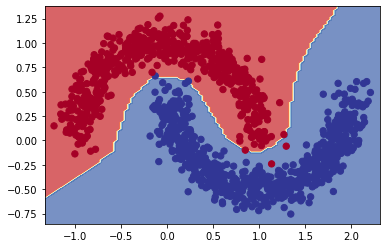

In [21]:
plot_decision_boundary(net, X_test, y_test)